In [143]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use("dark_background")


In [144]:
# load data
df = pd.read_csv("data/AirPassengers.csv")
print(df.dtypes)
df

Month          object
#Passengers     int64
dtype: object


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [145]:
#changing Month from object type to datetime
df['Month'] = pd.to_datetime(df['Month'])
print(df.dtypes)

Month          datetime64[ns]
#Passengers             int64
dtype: object


In [146]:
#index column replaced by month column
df.set_index('Month', inplace=True)

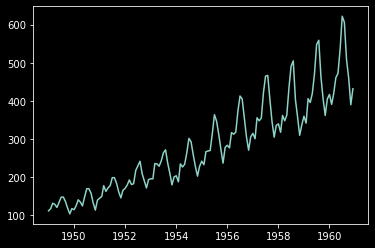

In [147]:
plt.plot(df['#Passengers'])

In [148]:
# Check for data stationary
#Dickey-Fuller test

from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ =adfuller(df['#Passengers'])
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")

pvalue =  0.991880243437641  if above 0.05, data is not stationary


Since the p-value is above 0.05, we know is not stationary and we need to use SARIMA

In [149]:
df['year'] = [d.year for d in df.index]
df['month'] = [d.strftime('%b') for d in df.index]
years = df['year'].unique()

<AxesSubplot:xlabel='year', ylabel='#Passengers'>

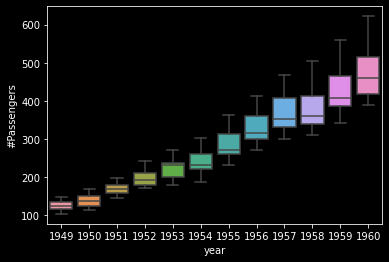

In [150]:
sns.boxplot(x='year', y='#Passengers', data=df)

<AxesSubplot:xlabel='month', ylabel='#Passengers'>

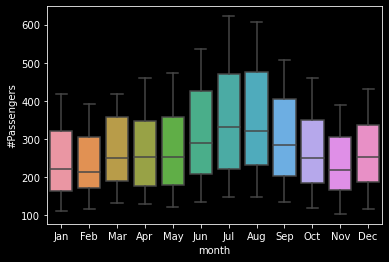

In [151]:
sns.boxplot(x='month', y='#Passengers', data=df)

In [152]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposed = seasonal_decompose(df['#Passengers'],
                               model = 'additive')

In [153]:
#Additive time series:
#Value = Base level + Trend + Seasonality + Error
#Multiplcative time series:
#Value = Base level x Trend x Seasonality x Error

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

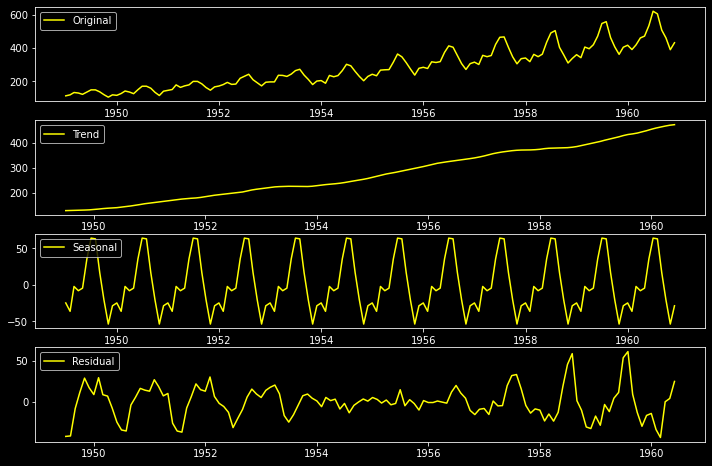

In [154]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(df['#Passengers'], label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

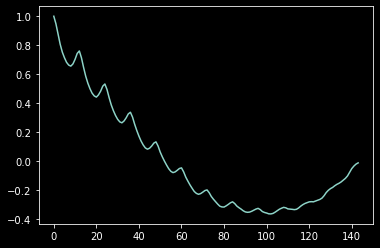

In [155]:
from statsmodels.tsa.stattools import acf

acf_144 = acf(df['#Passengers'], nlags=144)
plt.plot(acf_144)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

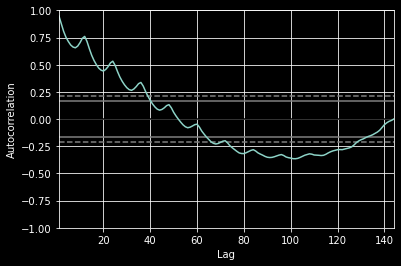

In [156]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['#Passengers'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

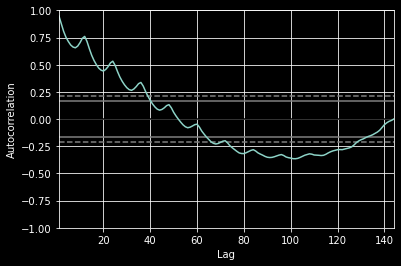

In [157]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['#Passengers'])

In [158]:
import pmdarima
from pmdarima.arima import auto_arima

# p - number of autoregressive term(AR)
# q - number of moving average term(MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components


arima_model = auto_arima(df['#Passengers'], start_p = 1, d=1, start_q = 1,
                        max_p = 5, max_q = 5, max_d=5, m=12,
                        start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                        seasonal = True, 
                        trace = True,
                        error_action = 'ignore',
                        suppress_warnings = True,
                        stepwise = True, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.03 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.11 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.14 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=1.75 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.08 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.15 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.21 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.12 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [159]:
print(arima_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Sat, 15 Oct 2022   AIC                           1019.178
Time:                                     17:20:07   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      

In [160]:
#split data into train and test

size = int(len(df) * 0.66)
x_train, x_test = df[0:size], df[size:len(df)]


In [161]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(x_train['#Passengers'],
               order = (0,1,1), 
               seasonal_order = (2, 1, 1, 12))

result = model.fit()
result.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18325D+00    |proj g|=  8.53320D-02

At iterate    5    f=  3.17656D+00    |proj g|=  1.41381D-02

At iterate   10    f=  3.16650D+00    |proj g|=  2.35305D-02

At iterate   15    f=  3.16207D+00    |proj g|=  1.13175D-02


/Users/nostest/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/nostest/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  3.16108D+00    |proj g|=  6.86510D-03

At iterate   25    f=  3.16080D+00    |proj g|=  4.42563D-04

At iterate   30    f=  3.16073D+00    |proj g|=  4.04972D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     53      1     0     0   6.636D-04   3.161D+00
  F =   3.1607163283623994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.268
Date:                            Sat, 15 Oct 2022   AIC                            610.536
Time:                                    17:20:08   BIC                            622.570
Sample:                                01-01-1949   HQIC                           615.367
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3186      0.103     -3.101      0.002      -0.520      -0.117
ar.S.L12       0.6852      0.601      1.140      0.254      -0.493       1.864
ar.S.L24       0.3139      0.126      2.485      0.013       0.066       0.562
ma.S.L12      -0.9833      6.011     -0.164      0.870     -12.764      10.798
sigma2        78.4725    424.594      0.185      0.853    -753.717     910.662
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.96   Prob(JB):                         0.28
Heteroskedasticity (H):               1.69   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
#Train prediction

start_index = 0
end_index = len(x_train)-1
train_prediction = result.predict(start_index, end_index)


In [163]:
#Prediction

start_index = len(x_train)
end_index = len(df)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers')

<AxesSubplot:xlabel='Month'>

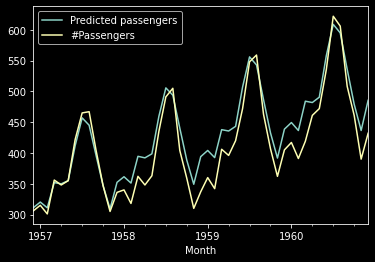

In [164]:
#Plot predictions and actual values

prediction.plot(legend = True)
x_test['#Passengers'].plot(legend = True)

In [165]:
import math
from sklearn.metrics import mean_squared_error

In [166]:
del x_train['year']
del x_train['month']
del x_test['year']
del x_test['month']

In [167]:
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(x_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))


Train Score: 16.14 RMSE


In [168]:
testScore = math.sqrt(mean_squared_error(x_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 29.40 RMSE


In [170]:
forecast = result.predict(start = len(df),
                         end = (len(df)-1) + 3 * 12,
                         typ = 'levels').rename('Forecast')



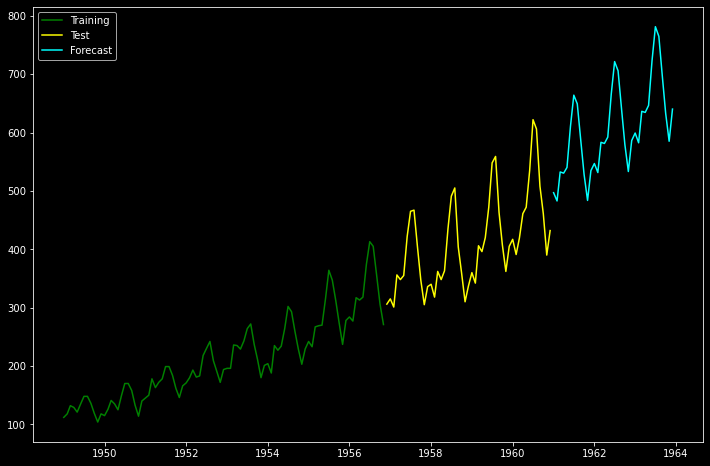

In [173]:
plt.figure(figsize=(12,8))
plt.plot(x_train, label='Training', color='green')
plt.plot(x_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='upper left')
plt.show()